In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
import matplotlib.pyplot as plt
import torch.optim as optim
import torchmetrics
import numpy as np
import random

In [2]:
# Set the seed
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [3]:
# mean and sd for images size 299,299
mean = [0.1854, 0.1854, 0.1855]
std = [0.2005, 0.2005, 0.2005]

train_ratio = 0.8 # train, valid split
batch_size = 32
epochs = 10
lr = 0.00005

# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [5]:
# Load the datasets
train_dataset = datasets.ImageFolder(root="../data/Training", transform=data_transform)
test_dataset = datasets.ImageFolder(root="../data/Testing", transform=data_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Split Train into Train, Valid
train_size = int(train_ratio * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
# Initialize Inception V3 Model
model = models.inception_v3(weights=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(train_dataset.classes))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

c:\Users\jesdi\.conda\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# summary(model, input_size=(1, 3, 299, 299))

In [8]:
auc_metric = torchmetrics.AUROC(task="multiclass", num_classes=len(train_dataset.classes)).to(device)
confusion_matrix_metric = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

In [9]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    train_loss, train_auc, val_loss, val_auc = [], [], [], []
    best_val_loss = float('inf') 
    
    for epoch in range(num_epochs):
        model.train()
        loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Clear previous gradients
            optimizer.zero_grad()
            
            # Inception v3 has two outputs: primary and auxiliary
            outputs, aux_outputs = model(images)  
            # calculate weighted loss
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            _loss = loss1 + 0.4 * loss2
            
            # Backpropagate and update weights
            _loss.backward()  
            optimizer.step()
            
            loss += _loss.item()
            
            # Get predicted class
            _, preds = outputs.max(1)  
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
            
            auc_metric.update(outputs, labels)
            
        epoch_loss = loss / len(train_loader)
        accuracy = 100 * correct / total
        train_loss.append(epoch_loss)
        train_auc.append(auc_metric.compute().item())
        auc_metric.reset()
        
        # Validation Phase
        model.eval()
        loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _loss = criterion(outputs, labels)
                
                loss += _loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
                auc_metric.update(outputs, labels)
        
        val_epoch_loss = loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_loss.append(val_epoch_loss)
        val_auc.append(auc_metric.compute().item())
        auc_metric.reset()
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Train Acc: {accuracy:.2f} - Val Loss: {val_epoch_loss:.4f} - Val Accuracy: {val_accuracy:.2f}%")
        
        # Save model if validation loss is the lowest so far
        if val_epoch_loss < best_val_loss:
            # print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
            best_val_loss = val_epoch_loss
            torch.save(model.state_dict(), '../models/inception_v3.pth')  # Save the model's parameters
    
    return train_loss, train_auc, val_loss, val_auc

In [10]:
# Train the model
train_loss, train_auc, val_loss, val_auc = train_model(model, train_loader, criterion, optimizer, num_epochs=epochs)

Epoch 1/10 - Train Loss: 0.8299 - Train Acc: 86.96 - Val Loss: 0.1150 - Val Accuracy: 96.41%
Epoch 2/10 - Train Loss: 0.1077 - Train Acc: 97.86 - Val Loss: 0.0600 - Val Accuracy: 97.90%
Epoch 3/10 - Train Loss: 0.0416 - Train Acc: 99.23 - Val Loss: 0.0576 - Val Accuracy: 98.08%
Epoch 4/10 - Train Loss: 0.0294 - Train Acc: 99.45 - Val Loss: 0.0628 - Val Accuracy: 98.08%
Epoch 5/10 - Train Loss: 0.0241 - Train Acc: 99.61 - Val Loss: 0.0775 - Val Accuracy: 97.55%
Epoch 6/10 - Train Loss: 0.0139 - Train Acc: 99.78 - Val Loss: 0.0715 - Val Accuracy: 97.81%
Epoch 7/10 - Train Loss: 0.0190 - Train Acc: 99.76 - Val Loss: 0.0612 - Val Accuracy: 98.25%
Epoch 8/10 - Train Loss: 0.0124 - Train Acc: 99.78 - Val Loss: 0.0731 - Val Accuracy: 98.08%
Epoch 9/10 - Train Loss: 0.0071 - Train Acc: 99.91 - Val Loss: 0.0542 - Val Accuracy: 98.25%
Epoch 10/10 - Train Loss: 0.0040 - Train Acc: 100.00 - Val Loss: 0.0579 - Val Accuracy: 98.25%


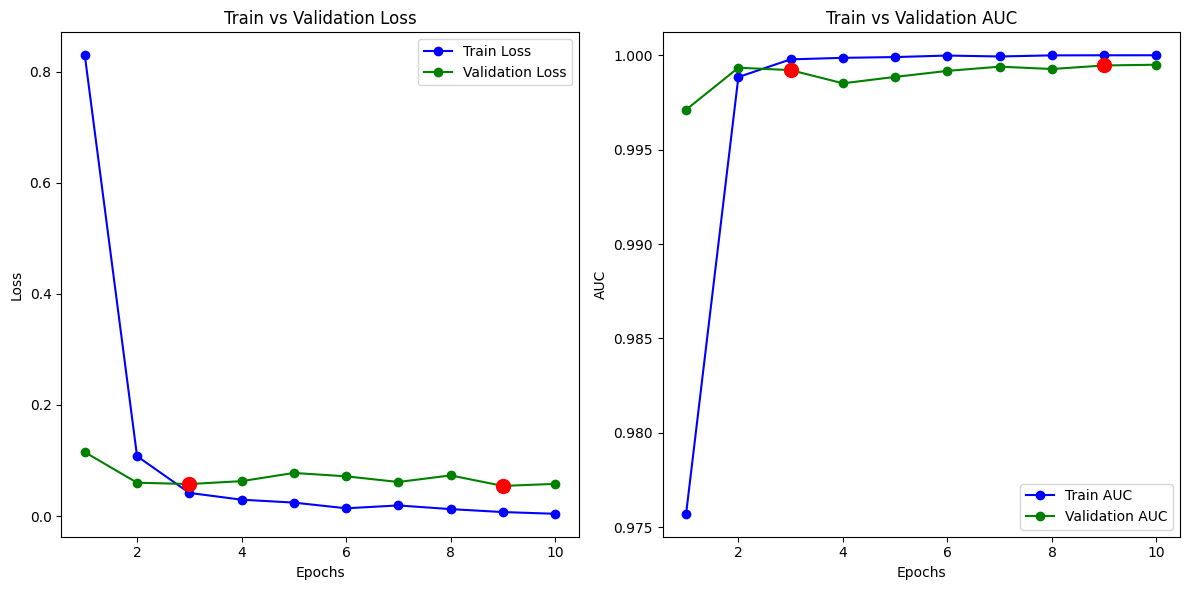

In [ ]:
epochs = range(1, epochs + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", color='b', marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", color='g', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.scatter(3, val_loss[2], color='r', s=100, zorder=5) 
plt.scatter(9, val_loss[8], color='r', s=100, zorder=5) 

plt.subplot(1, 2, 2)
plt.plot(epochs, train_auc, label="Train AUC", color='b', marker='o')
plt.plot(epochs, val_auc, label="Validation AUC", color='g', marker='o')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Train vs Validation AUC')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(3, val_auc[2], color='r', s=100, zorder=5) 
plt.scatter(9, val_auc[8], color='r', s=100, zorder=5)

plt.tight_layout()
plt.show()